### Load downsampled annotation file and identify location

Major May 2022 update! 

Associated each point with an atlas ID based on full allen brain atlas directly fetched from allenSDK
(split to left and right hemisphere for axons)

Project downsampled points in to tiff file for illustration purposes (ie, can overlay to brain image stack or template stack)

Plot as bar graph

Plot as full resolution 3D scatter plot with hover region name

In [1]:
import os

import pandas as pd

import numpy as np

import SimpleITK as sitk

import warnings

import tkinter.filedialog as fdialog

import skimage
from skimage import io

import random

import matplotlib.pyplot as plt

import re

import Neuron_analysis as na
from Neuron_analysis import *

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
points_name=fdialog.askopenfile( title='Select the downsampled axon points').name
Dpoints_name=fdialog.askopenfile( title='Select the downsampled dendritic points').name

outdir = fdialog.askdirectory(title='Please select the output directory')

mcc = MouseConnectivityCache(resolution=25)

annot, annot_info = mcc.get_annotation_volume()

Coronal atlas has shape (528, 320, 456)
Converted to horizontal atlas with shape (456, 528, 320)


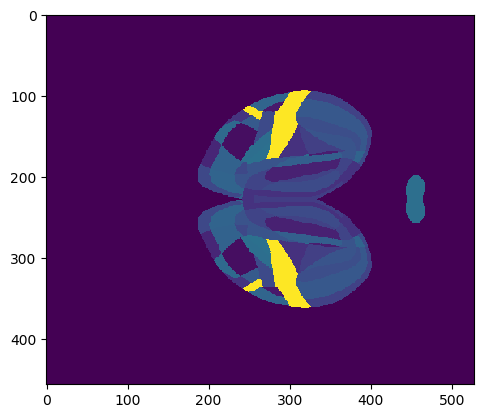

In [3]:
print('Coronal atlas has shape', annot.shape)

annot_h=np.moveaxis(annot, 2, 0) #reslice corontal atlas to horizontal atlas
print('Converted to horizontal atlas with shape', annot_h.shape)

plt.imshow(annot_h[:,:,36], interpolation='nearest', vmin=0, vmax=3000)
plt.show()
# although in this plot it looks like the image should rotate 90 degrees to the right but it actually matches the dimension of image

In [5]:
# Load the csv file containing the labels
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')
mouse_name= na.find_mousename(points_name)

out_name= os.path.join(outdir,mouse_name)

out_name

'D:/SingleNeuron_results\\AL223'

In [9]:
def readandrefill(points_fname, to_add):
    
    all_points=[]
    
    with open(points_fname,'r') as output:
        outputpoint= output.readlines()

        for lines in outputpoint:
            m=re.search("(?:OutputIndexFixed = \[ )([0-9]+ [0-9]+ [0-9]+)", lines).groups(0)
            this_line= str(m[0]).split(' ')
            mypoints= [int(stuff) for stuff in this_line]
            mypoints[1]= mypoints[1]+to_add
            all_points.append(mypoints)
    return all_points


def make_tif(all_points, atlas_shape, outname):
    ''' Project downsampled points on to a tif stack, useful for overlaping with brain or template (ie, in imageJ)
    input: downsampled points in a list containing x y z ordinates as int, directory containing it (this is also the output directory) and whether annotation is axon or not (default True)
    example: [[12, 13, 25],
             [13, 14, 25],...]
    
    output: a tiff stack with the same dimensions of the template/atlas mhd files with downsampled points only
    each point has a value of the number of occurences (since downsampling combines multiple points as one)
    '''
        
    print('Starting to saving tif files..')
    
    svolume=np.zeros(atlas_shape)
    #columns, rows, planes

    zplanes=[]
    for i in all_points:
        zplanes.append( i[2])
    zplanes=np.unique(zplanes)
    temp=np.zeros(atlas_shape[0:2])
    thepoints=np.asarray(all_points)

    for i in zplanes:
        index= thepoints[:,2]==i
        uindex,counts=np.unique(thepoints[index],return_counts=True, axis=0)
        for j, lines in enumerate(uindex):
            coord1,coord2=lines[0:2]
            temp[coord1][coord2]= counts[j]
        svolume[:,:,i]=temp #write this in 
        temp=np.zeros(atlas_shape[0:2]) #reset the empty plane after each z


    coronal_planetmp= np.swapaxes(np.int16(svolume),0,2)
    #for some reason, if just save stuff as tiff, it will save x planes of yz view
    #here we shift the 3rd dimension with the first dimension to obtain xy view

    io.imsave(outname,coronal_planetmp)
    return 

def regions_csv(points, out_name):
    points_in_atlas=[int(annot_h[i[0], i[1],i[2]]) for i in points]
    
    points_in_atlas= np.where(points_in_atlas==0, 981, points_in_atlas) 
    # replace id= 0 with 981 (ssp-bfd layer1)

    points_in_atlas= np.where(points_in_atlas==484682520, 484682528 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==484682524, 484682528 , points_in_atlas)
    # replace id= 484682520 (optic radiation)  and id= 484682524 (auditory radiation) with 484682258, stc(a subregion of fiber bundle)
    # these are intrinsic issue of the allen atlas, the labels for these regions are wrong
    
    points_in_atlas= np.where(points_in_atlas==0, 981, points_in_atlas) 
    # somehow this line needs to be ran twice??
    unique_id, counts = np.unique(points_in_atlas, return_counts=True)
    id_withcounts=list(zip(unique_id, counts))

    our_regions=na.atlas_labels.loc[na.atlas_labels['id'].isin (unique_id)]

    new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
    our_regionWcounts=pd.merge(na.atlas_labels, new_df)
    
    our_regionWcounts.to_excel(out_name+'region_with_counts.xls',index=None,header=True)

    return points_in_atlas, our_regionWcounts

def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'counts': grouped_pd.counts}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, na.atlas_labels, on=["id"])
    result.sort_values(['counts'], ascending=True, inplace=True)
    # result is the final pd

    return result

In [7]:
# refill y section

template_file = [x for x in os.listdir(f'D:\{mouse_name}\\') if 'template' in x]
to_add=na.find_crop(template_file[0])

all_points=readandrefill(points_name,to_add)

In [10]:
make_tif(all_points,annot_h.shape,out_name+'_axons.tif') #Projects the points in the atlas space for visualization /verification purposes

Starting to saving tif files..


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/SingleNeuron_results\AL223_axons.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [11]:
# Identify left and right hemisphere by splitting x in half
left_points= []
right_points= []
for item in all_points:
    if item[0]<227:
        left_points.append(item)
    else:
        right_points.append(item)

In [19]:
#len(right_points)

In [17]:
points_in_atlasR,regionsR= regions_csv(right_points,out_name+'_axon_right_')
points_in_atlasL,regionsL= regions_csv(left_points,out_name+'_axon_left_')

C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


In [22]:
regionsL.head()

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,counts
0,1047,979.0,"Primary somatosensory area, barrel field, layer 4",SSp-bfd4,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/1047/,188064,NaN,NaN,f,55,3439709501,734881840,Primary somatosensory area barrel field layer 4,8967
1,156,1009.0,"Dorsal auditory area, layer 6a",AUDd6a,11,1,3,8690,1011.0,8,...,/997/8/567/688/695/315/247/1011/156/,019399,NaN,NaN,f,128,2489109267,734881840,Dorsal auditory area layer 6a,681
2,461,623.0,"Primary somatosensory area, trunk, layer 6b",SSp-tr6b,11,1,3,8690,361.0,9,...,/997/8/567/688/695/315/453/322/361/461/,188064,NaN,NaN,f,93,3360815570,734881840,Primary somatosensory area trunk layer 6b,99
3,945,1108.0,"Primary somatosensory area, upper limb, layer 6a",SSp-ul6a,11,1,3,8690,369.0,9,...,/997/8/567/688/695/315/453/322/369/945/,188064,NaN,NaN,f,85,2726127758,734881840,Primary somatosensory area upper limb layer 6a,105
4,954,1109.0,"Primary auditory area, layer 6a",AUDp6a,11,1,3,8690,1002.0,8,...,/997/8/567/688/695/315/247/1002/954/,019399,NaN,NaN,f,142,945654628,734881840,Primary auditory area layer 6a,717


In [23]:
regionsR

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,counts
0,484682516,NaN,"corpus callosum, body",ccb,9,1,3,8690,776.0,4,...,/997/1009/983/776/484682516/,CCCCCC,NaN,NaN,f,1199,1909459776,734881840,corpus callosum body,1799


In [15]:
dendrites= readandrefill(Dpoints_name,to_add)

In [16]:
make_tif(dendrites,annot_h.shape,out_name+'_dendrites.tif')

Starting to saving tif files..


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/SingleNeuron_results\AL223dendrites.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [18]:
points_in_atlasD,regionsD= regions_csv(dendrites,out_name+'_dendrites_')

C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


In [128]:
regionsD

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,counts
0,201,1015.0,"Primary somatosensory area, barrel field, laye...",SSp-bfd2/3,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/201/,188064,NaN,NaN,f,54,1738869888,734881840,Primary somatosensory area barrel field layer 2/3,4816
1,981,971.0,"Primary somatosensory area, barrel field, layer 1",SSp-bfd1,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/981/,188064,NaN,NaN,f,53,3178183090,734881840,Primary somatosensory area barrel field layer 1,3936


In [129]:
# Generate excel file of regions in parent name (1 graph order up) for each hemisphere
axon_subL=regionsL.sort_values(by=['counts'])
axon_subL.sort_values(by= 'graph_order',axis=0, inplace=True)
parentL= parent_df(axon_subL)
parentL.sort_values('counts',ascending=False, inplace=True)

parentL.to_excel(f'{out_name}_Lparent.xls') 

In [132]:
# Generate excel file of regions in parent name (1 graph order up) for each hemisphere

axon_subR=regionsR.sort_values(by=['counts'])
axon_subR.sort_values(by= 'graph_order',axis=0, inplace=True)
parentR= parent_df(axon_subR)

parentR.sort_values('counts',ascending=False, inplace=True)

parentR.to_excel(f'{out_name}_Rparent.xls') 

## Plotting section- bar graphs

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [122]:
def arrange_parent_subregion(parentdf,subregiondf):
    new_order=parentdf.id.to_numpy()
    
    old_order= subregiondf.parent_structure_id.to_numpy()   
    
    print('Old parent region id order is: ', old_order)
    print('New parent region id order is: ', new_order)
    
    
    new_array= np.zeros_like(old_order)
    for i, j in enumerate(new_order):
        new_array[old_order==j]=i
        
    print('Re-arranged subregion order based on parent region that has the greatest number of axon: ', new_array)
    
    subregiondf['new_order']= new_array
    subregiondf.sort_values('new_order', inplace=True)
    
    subregiondf.sort_values(by=['new_order', 'graph_order'], ascending=[True, True] ,inplace=True)

    return subregiondf

def plot_hist(pd_axonL,pd_axonR, pd_dendrite,out_name):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, mousename
    '''

    fig = make_subplots(
        shared_yaxes=True,
        rows=3, cols=1,
        row_heights=[0.85, 0.05,0.1],
        row_titles=['Left axons', 'Right axons', 'Dendrites']
    )
    
    fig.add_trace(
        go.Bar(
        y=pd_axonL['acronym'], x=pd_axonL['counts']/1000, # units now in milimeters
        marker_color='red', #for future, pd_axon['region_id'],
        name='',
        text=pd_axonL['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    
    fig.add_trace(
        go.Bar(
        y=pd_axonR['acronym'], x=pd_axonR['counts']/1000, # units now in milimeters
        marker_color='magenta', #for future, pd_axon['region_id'],
        name='',
        text=pd_axonR['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )
    

    fig.add_trace(
        go.Bar(
        y=pd_dendrite['acronym'], x=pd_dendrite['counts']/1000, # units now in milimeters
        marker_color='black',
        name='',
        text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=3,col=1
    )

    
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      width=2000,
                      height=1000, # 1500 for AL066 since too many items
                      showlegend= False,
                      paper_bgcolor='rgba(0,0,0,0)', # transparent background
                      plot_bgcolor='rgba(0,0,0,0)' # transparent background
                     )
    
    fig.update_xaxes(gridcolor='gold')
    
    fig.show()

    fig.write_image(f"{out_name}.svg")
    fig.write_html(f"{out_name}.html")

In [135]:

print('For left hemisphere')
new_axonL= arrange_parent_subregion(parentL,axon_subL)

print('For right hemisphere')
new_axonR= arrange_parent_subregion(parentR,axon_subR)


For left hemisphere
Old parent region id order is:  [3.29000000e+02 3.29000000e+02 3.29000000e+02 3.29000000e+02
 3.29000000e+02 7.76000000e+02 1.01800000e+03 1.01800000e+03
 1.00200000e+03 1.01100000e+03 3.78000000e+02 7.68000000e+02
 1.82305689e+08 1.82305689e+08 1.82305689e+08 1.82305689e+08
 3.61000000e+02 3.61000000e+02 3.61000000e+02 3.69000000e+02
 3.69000000e+02 5.41000000e+02 1.00900000e+03 3.37000000e+02]
New parent region id order is:  [      329       776      1018      1002      1011       378       768
 182305689       361       369       541      1009       337]
Re-arranged subregion order based on parent region that has the greatest number of axon:  [ 0.  0.  0.  0.  0.  1.  2.  2.  3.  4.  5.  6.  7.  7.  7.  7.  8.  8.
  8.  9.  9. 10. 11. 12.]
For right hemisphere
Old parent region id order is:  [776.]
New parent region id order is:  [776]
Re-arranged subregion order based on parent region that has the greatest number of axon:  [0.]


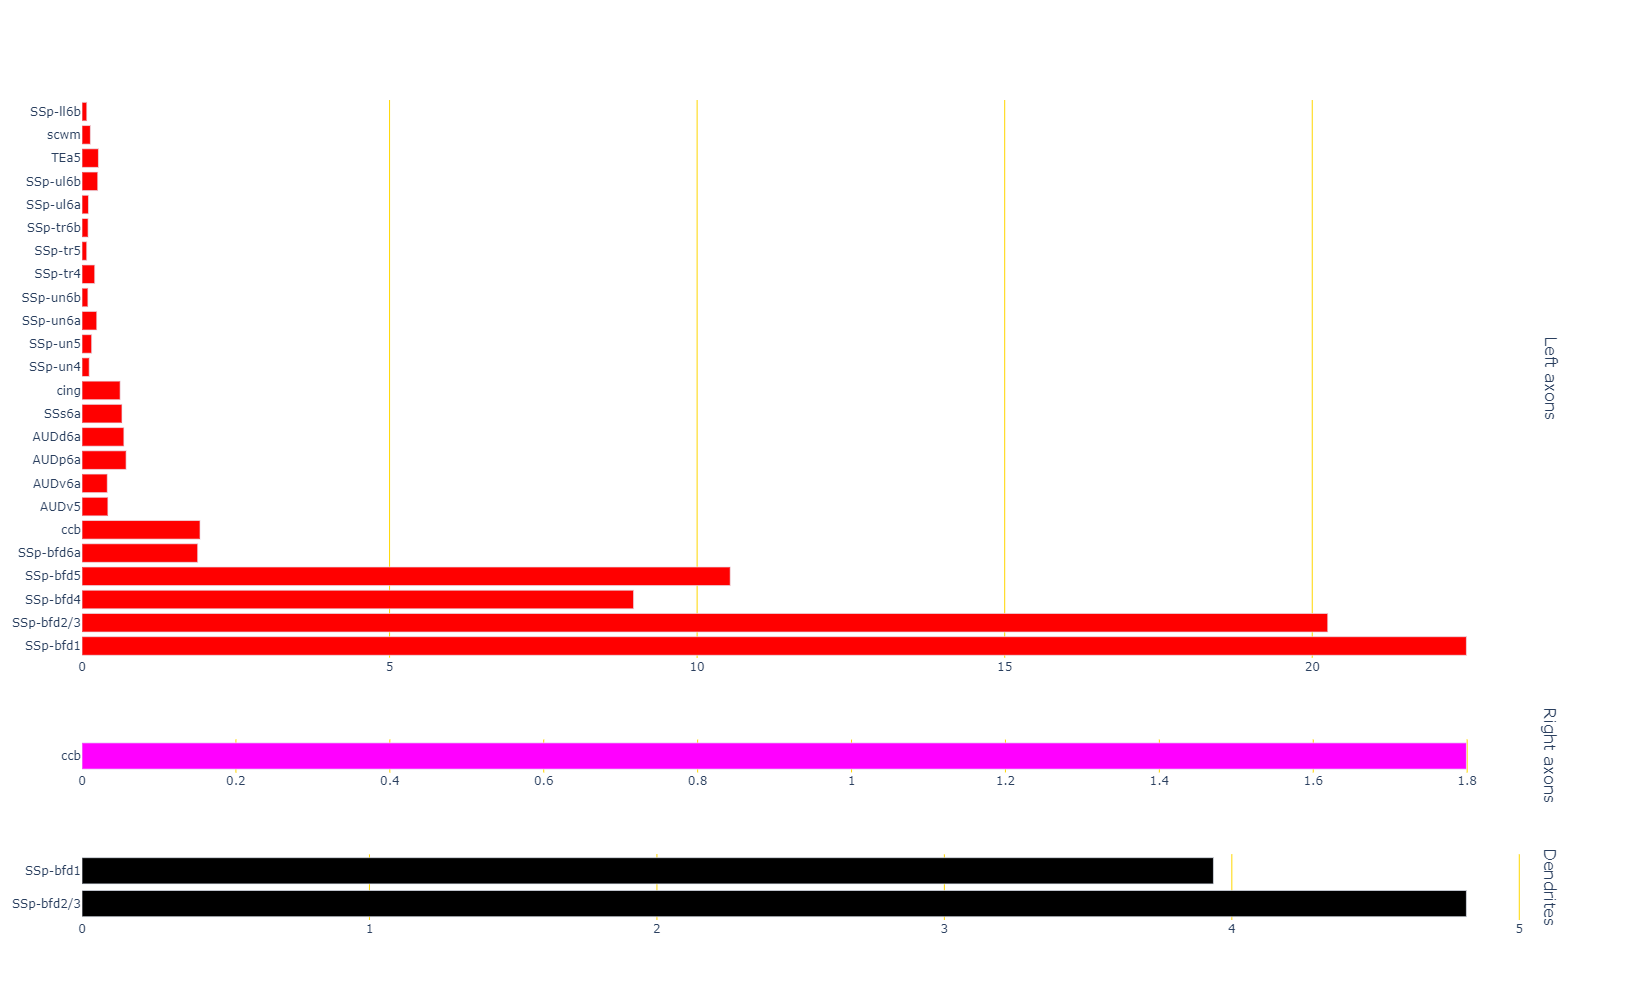

In [140]:
plot_hist(new_axonL,new_axonR,regionsD,out_name)

## Plots the non'downsampled points in 3d space 
WORK IN PROGRESS!!!

In [18]:
import plotly
import plotly.graph_objects as go
from plotly import __version__
print(__version__)


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

4.5.0


In [19]:
ori_points_name=fdialog.askopenfile( title='Select the converted&resampled origional points').name

#Load the origional points
anno=open(ori_points_name,'r')
anno_data=anno.readlines()
# heading is stored in anno_data[2], 1st line basically useless

headings=anno_data[2].rstrip('\n').replace(' ', '').split(',')
annotations=[lines.rstrip(' 0\n').split(' ') for lines in anno_data[3:]]
#slight modification on replacing and stripping due to the format of the resampled swc
annotation_df=pd.DataFrame(annotations, columns=headings)

annotation_df.head()

,#id,type,x,y,z,r,pid
0,1,3,4811.63,2360.22,3550.49,1,2
1,2,3,4812.59,2360.24,3550.77,1,3
2,3,3,4813.55,2360.27,3551.06,1,4
3,4,3,4814.49,2360.24,3551.37,1,5
4,5,3,4815.36,2360.01,3551.81,1,6


In [20]:
points_with_id= pd.DataFrame (zip(annotation_df['x'],annotation_df['y'], annotation_df['z'],points_in_atlas ), columns=['x', 'y','z', 'atlasID'])
points_with_id.to_csv (outdir+'/resamp_oripoints_withID.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
points_with_id.head(10)

,x,y,z,atlasID
0,4811.63,2360.22,3550.49,971
1,4812.59,2360.24,3550.77,971
2,4813.55,2360.27,3551.06,971
3,4814.49,2360.24,3551.37,971
4,4815.36,2360.01,3551.81,971
5,4816.23,2359.79,3552.25,971
6,4817.13,2359.73,3552.67,971
7,4818.03,2359.75,3553.1,971
8,4818.89,2360,3553.54,971
9,4819.75,2360.24,3553.99,971


In [21]:
len(points_with_id)
# this is the total length (in um) of the trace if the trace is resampled in 1um steps

102165

In [22]:
#Assign a colour to each unique atlas ID for plotting
#this is need because atlas IDs has very high values which is outside of the colour range
uniqueID=np.unique(points_with_id['atlasID'])
colour= np.linspace(1,np.size(uniqueID)+1, num=np.size(uniqueID),dtype='int')

colourdict=dict(zip(uniqueID,colour))

In [74]:
#colourdict=dict(zip(atlas_labels['id'], atlas_labels['color_hex_triplet']))
# cannot use the allen atlases colour because some are not recognized by plotly

In [23]:
namedict=dict(zip(atlas_labels['id'],atlas_labels['name']))
points_with_id['name'] = points_with_id['atlasID'].map(namedict)

points_with_id['colour'] = points_with_id['atlasID'].map(colourdict)
points_with_id.head()

,x,y,z,atlasID,name,colour
0,4811.63,2360.22,3550.49,971,"corpus callosum, posterior forceps",26
1,4812.59,2360.24,3550.77,971,"corpus callosum, posterior forceps",26
2,4813.55,2360.27,3551.06,971,"corpus callosum, posterior forceps",26
3,4814.49,2360.24,3551.37,971,"corpus callosum, posterior forceps",26
4,4815.36,2360.01,3551.81,971,"corpus callosum, posterior forceps",26


In [24]:
trace= go.Scatter3d( 
    x=points_with_id[::3]['x'],
    y=points_with_id[::3]['y'],
    z=points_with_id[::3]['z'],
    mode='markers',
    marker=dict(
        size=1,
        color=points_with_id[::3]['colour'],
        opacity=0.5),
    hovertext= points_with_id[::3]['name'],
    hoverinfo='text'
)

layout=go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0)
)

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
camera = dict(
    eye=dict(x=0, y=-1, z=0)
)


#Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
fig=go.Figure(data=trace,layout=layout)
fig.update_layout(scene_camera=camera, 
                  scene=dict(
                    xaxis_title='Smaller=more medial',
                    yaxis_title='Smaller=more dorsal',
                    zaxis_title='Smaller=more anterior'))
plot(fig,filename=outdir+'/'+ outdir[3:8]+'resampled3Dplot.html')

'D:/AL066/AL066resampled3Dplot.html'